#M2 Individual Assignment: Palette Archetypes via Clustering and Association Rules - Bob Ross Paintings

Team ID: B1 Team 3

Student Name: Yihui (Irene) Tang

**Question:**

Do Bob Ross paintings form a small number of interpretable palette archetypes based on binary paint usage?

**Method**
1. Clustering: discorver archetypes - unsupervised grouping
2. Association Rules: validation and explanation - unsupervised pattern mining

##0.Load and Explore the Dataset

In [114]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances

from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [115]:
bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [116]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##1.Data Overview

In [117]:
print(f"Dataset size: {bob_ross.shape}")
print("\nColumn types:")

display(bob_ross.head())

Dataset size: (403, 27)

Column types:


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [118]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

In [119]:
# Check for missing values
print("Missing values check:")
missing = bob_ross.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  No missing values found")

# Check for duplicates
print(f"\nDuplicate paintings: {bob_ross.duplicated().sum()}")

Missing values check:
  No missing values found

Duplicate paintings: 0


##2.EDA

###2.1 Identify paint cols

In [120]:
paint_cols = bob_ross.select_dtypes(include=["bool"]).columns.tolist()

print("Number of paint columns:", len(paint_cols))
print("Paint columns:", paint_cols)

Number of paint columns: 18
Paint columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']


I encode each painting as a binary “palette” over the 18 paints. With this setup, I can cluster paintings to define palette archetypes and then use association rules to summarize stable co-usage patterns inside each archetype. Each row is a painting. Now, each column is a paint (0/1).

###2.2 Paint Count Summary

In [121]:
X = bob_ross[paint_cols].astype(int)
bob_ross["paint_count"] = X.sum(axis=1)
display(X.describe().T[["mean", "std", "min", "max"]].sort_values("mean", ascending=False).head(10))
display(bob_ross["paint_count"].describe())

,mean,std,min,max
Titanium_White,0.992556,0.086065,0.0,1.0
Alizarin_Crimson,0.942928,0.232268,0.0,1.0
Van_Dyke_Brown,0.920596,0.270705,0.0,1.0
Cadmium_Yellow,0.858561,0.348907,0.0,1.0
Yellow_Ochre,0.811414,0.391665,0.0,1.0
Phthalo_Blue,0.801489,0.399375,0.0,1.0
Bright_Red,0.796526,0.403082,0.0,1.0
Midnight_Black,0.786600,0.410217,0.0,1.0
Sap_Green,0.759305,0.428037,0.0,1.0
Indian_Yellow,0.724566,0.447288,0.0,1.0


,paint_count
count,403.000000
mean,10.605459
std,2.378525
min,1.000000
25%,9.000000
50%,11.000000
75%,12.000000
max,15.000000


This is a simple proxy for palette complexity. Need for later to check if clusters differ in complexity.

###2.3 Paint Count Distribution

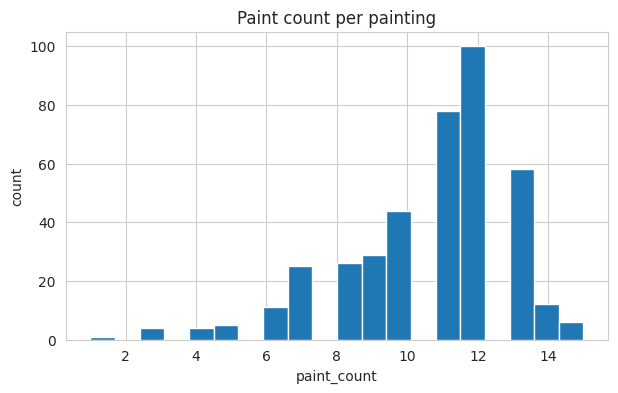

In [122]:
plt.figure(figsize=(7,4))
plt.hist(bob_ross["paint_count"], bins=20)
plt.title("Paint count per painting")
plt.xlabel("paint_count")
plt.ylabel("count")
plt.show()

If paint_count varies a lot, palette styles may differ in complexity.

###2.4 Top Paint Prevalence

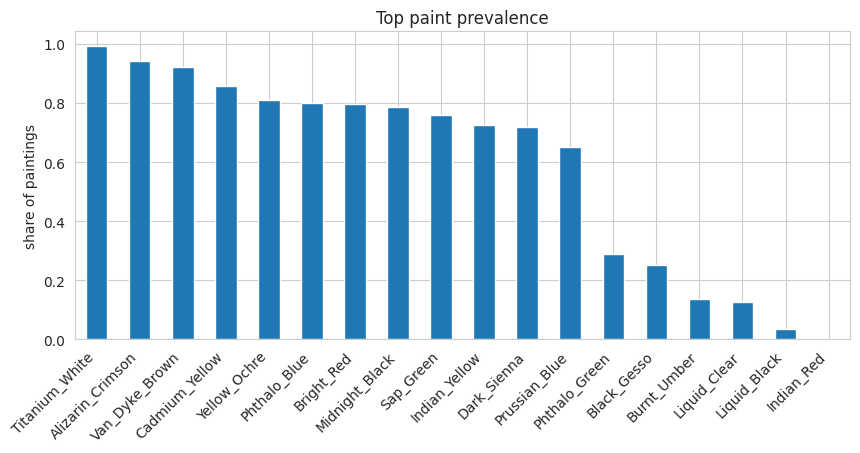

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


In [123]:
paint_prev = X.mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
paint_prev.head(20).plot(kind="bar")
plt.title("Top paint prevalence")
plt.ylabel("share of paintings")
plt.xticks(rotation=45, ha="right")
plt.show()

display(paint_prev.head(20))

A few paints appear in many paintings. For rules, lift matters because high-prevalence paints can create misleading co-occurrence.

###2.5 Structure Evidence

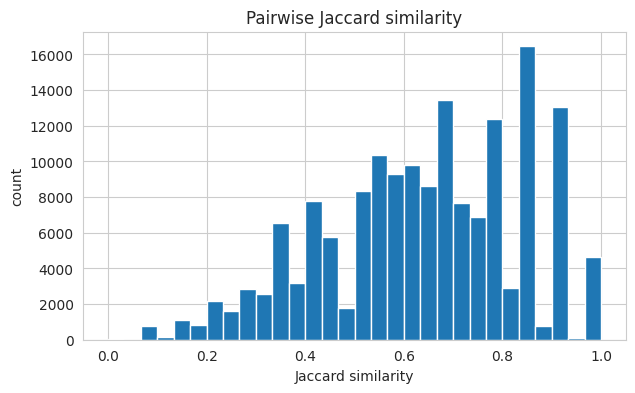

,0
count,162006.000000
mean,0.634615
std,0.200912
min,0.000000
25%,0.500000
50%,0.642857
75%,0.785714
max,1.000000


In [124]:
X_bool = X.to_numpy(dtype=bool)

D_jaccard = pairwise_distances(X_bool, metric="jaccard")
S_jaccard = 1 - D_jaccard

np.fill_diagonal(S_jaccard, np.nan)
sim_vals = S_jaccard[~np.isnan(S_jaccard)].ravel()

plt.figure(figsize=(7,4))
plt.hist(sim_vals, bins=30)
plt.title("Pairwise Jaccard similarity")
plt.xlabel("Jaccard similarity")
plt.ylabel("count")
plt.show()

display(pd.Series(sim_vals).describe())

###EDA Summary

The dataset has 403 paintings and 18 binary paint indicators, and I did not find missing values or duplicate rows in the fields used for this analysis. The number of paints used per painting varies, so palette complexity is not the same across episodes. A few paints show up in almost every painting (for example, Titanium_White), which suggests a shared baseline palette, while other paints are much rarer and may help separate specialized palette groups.

##3.Method

###3.1. Method 1: Agglomerative Clustering on Binary Paint Vectors

In [125]:
X_bool = X.to_numpy(dtype=bool)
D_jaccard = pairwise_distances(X_bool, metric="jaccard")

In [126]:
# Compute Distance Matrices
D_hamming = pairwise_distances(X_bool, metric="hamming")

print(f"Jaccard distance range: [{D_jaccard.min():.3f}, {D_jaccard.max():.3f}]")
print(f"Hamming distance range: [{D_hamming.min():.3f}, {D_hamming.max():.3f}]")

Jaccard distance range: [0.000, 1.000]
Hamming distance range: [0.000, 0.778]


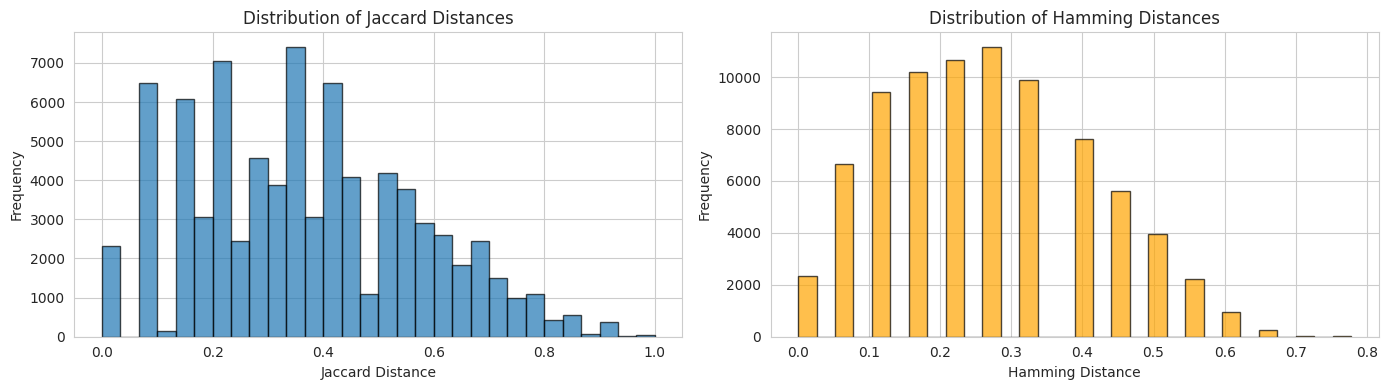

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

mask = np.triu(np.ones_like(D_jaccard, dtype=bool), k=1)
jaccard_vals = D_jaccard[mask]
hamming_vals = D_hamming[mask]

axes[0].hist(jaccard_vals, bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution of Jaccard Distances")
axes[0].set_xlabel("Jaccard Distance")
axes[0].set_ylabel("Frequency")

axes[1].hist(hamming_vals, bins=30, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Distribution of Hamming Distances")
axes[1].set_xlabel("Hamming Distance")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

I compare Jaccard and Hamming distances for the binary paint indicators. In my data, Jaccard distances are more dispersed than Hamming, which suggests it may separate paintings more clearly under a set-based notion of similarity.

In [128]:
# Build Dendrogram
Z = linkage(X_bool, method="average", metric="jaccard")

print("Linkage matrix shape:", Z.shape)

Linkage matrix shape: (402, 4)


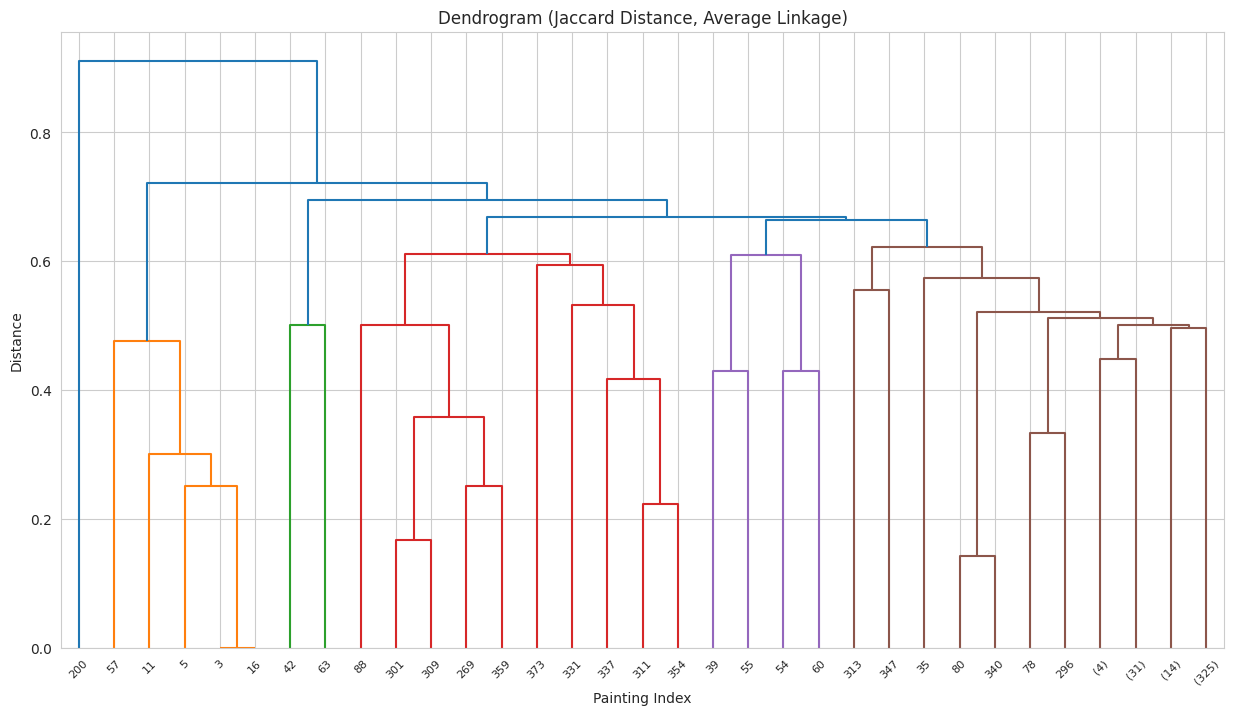

In [129]:
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='level', p=10)
plt.title("Dendrogram (Jaccard Distance, Average Linkage)")
plt.xlabel("Painting Index")
plt.ylabel("Distance")
plt.show()

I proceed with Jaccard because it focuses on overlap among paints that are actually used and does not count shared absences.

In [130]:
n_clusters = 5

bob_ross["cluster_labels"] = fcluster(Z, n_clusters, criterion="maxclust").astype(str)

In [131]:
bob_ross["cluster_labels"].value_counts()

,count
cluster_labels,
4,385
3,10
1,5
2,2
5,1


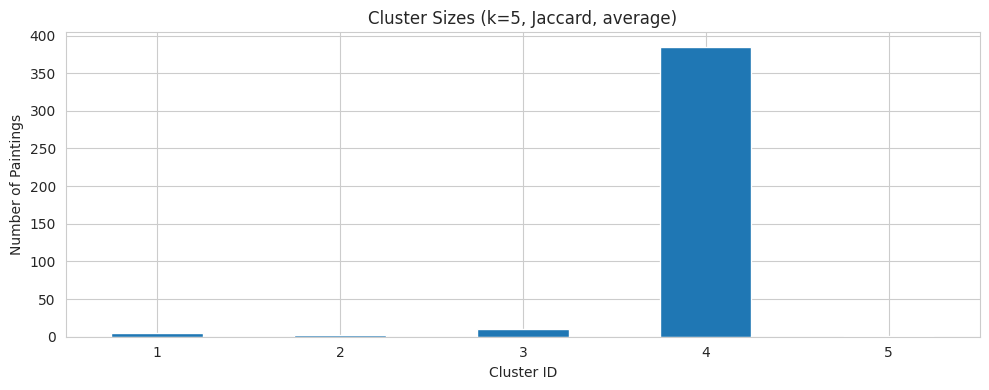

In [132]:
plt.figure(figsize=(10, 4))
bob_ross['cluster_labels'].value_counts().sort_index().plot(kind='bar')
plt.title(f"Cluster Sizes (k={n_clusters}, Jaccard, average)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Paintings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [133]:
cluster_sizes = bob_ross['cluster_labels'].value_counts().sort_index()
largest_cluster_pct = cluster_sizes.max() / len(bob_ross) * 100

print("Cluster Balance Analysis:")
print(f"  Largest cluster: {cluster_sizes.max()} paintings ({largest_cluster_pct:.1f}%)")
print(f"  Smallest cluster: {cluster_sizes.min()} paintings ({cluster_sizes.min()/len(bob_ross)*100:.1f}%)")
print(f"  Imbalance ratio: {cluster_sizes.max() / cluster_sizes.min():.1f}:1")

Cluster Balance Analysis:
  Largest cluster: 385 paintings (95.5%)
  Smallest cluster: 1 paintings (0.2%)
  Imbalance ratio: 385.0:1


In [134]:
df_cluster = X.copy()
df_cluster["cluster_labels"] = bob_ross["cluster_labels"].values
display(df_cluster.head())

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,cluster_labels
0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
2,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1
4,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4


I set n=5 based on the dendrogram cut and the resulting cluster size summary. I tried n=3 and n=4, most paintings collapse into one dominant cluster, which is too coarse to represent multiple palette archetypes. With 5 clusters, I still get one large “common palette” cluster, but I also recover several smaller, interpretable clusters that capture rarer paint combinations. I treat the very small clusters as potential outliers rather than forcing them into the dominant archetype.

In [135]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()
overall_rate = bob_ross[paint_cols].mean()
paint_lift = cluster_paint_rates / overall_rate

top_n = 8
for cl in cluster_paint_rates.index:
    print(f"\nCluster {cl} - top paints (usage rate):")
    display(cluster_paint_rates.loc[cl].sort_values(ascending=False).head(top_n))

    print(f"Cluster {cl} - top paints (lift vs overall):")
    display(paint_lift.loc[cl].sort_values(ascending=False).head(top_n))


Cluster 1 - top paints (usage rate):


,1
Van_Dyke_Brown,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Alizarin_Crimson,0.4
Liquid_Black,0.2
Black_Gesso,0.2
Indian_Yellow,0.2
Bright_Red,0.0


Cluster 1 - top paints (lift vs overall):


,1
Liquid_Black,5.757143
Prussian_Blue,1.532319
Van_Dyke_Brown,1.086253
Titanium_White,1.007500
Black_Gesso,0.798020
Alizarin_Crimson,0.424211
Indian_Yellow,0.276027
Bright_Red,0.000000



Cluster 2 - top paints (usage rate):


,2
Bright_Red,1.0
Burnt_Umber,1.0
Titanium_White,1.0
Prussian_Blue,1.0
Black_Gesso,0.5
Cadmium_Yellow,0.5
Midnight_Black,0.5
Indian_Yellow,0.5


Cluster 2 - top paints (lift vs overall):


,2
Burnt_Umber,7.327273
Black_Gesso,1.995050
Prussian_Blue,1.532319
Bright_Red,1.255452
Titanium_White,1.007500
Indian_Yellow,0.690068
Midnight_Black,0.635647
Cadmium_Yellow,0.582370



Cluster 3 - top paints (usage rate):


,3
Prussian_Blue,0.9
Titanium_White,0.9
Midnight_Black,0.8
Alizarin_Crimson,0.6
Phthalo_Blue,0.6
Black_Gesso,0.5
Sap_Green,0.5
Liquid_Clear,0.3


Cluster 3 - top paints (lift vs overall):


,3
Liquid_Clear,2.370588
Black_Gesso,1.995050
Prussian_Blue,1.379087
Midnight_Black,1.017035
Titanium_White,0.906750
Phthalo_Blue,0.748607
Sap_Green,0.658497
Alizarin_Crimson,0.636316



Cluster 4 - top paints (usage rate):


,4
Titanium_White,0.997403
Alizarin_Crimson,0.966234
Van_Dyke_Brown,0.948052
Cadmium_Yellow,0.893506
Yellow_Ochre,0.849351
Bright_Red,0.825974
Phthalo_Blue,0.823377
Midnight_Black,0.800000


Cluster 4 - top paints (lift vs overall):


,4
Dark_Sienna,1.046753
Indian_Red,1.046753
Yellow_Ochre,1.046753
Phthalo_Green,1.046753
Cadmium_Yellow,1.040703
Bright_Red,1.036971
Indian_Yellow,1.032414
Van_Dyke_Brown,1.029825



Cluster 5 - top paints (usage rate):


,5
Van_Dyke_Brown,1.0
Black_Gesso,0.0
Bright_Red,0.0
Burnt_Umber,0.0
Dark_Sienna,0.0
Cadmium_Yellow,0.0
Indian_Yellow,0.0
Liquid_Black,0.0


Cluster 5 - top paints (lift vs overall):


,5
Van_Dyke_Brown,1.086253
Black_Gesso,0.000000
Bright_Red,0.000000
Burnt_Umber,0.000000
Dark_Sienna,0.000000
Cadmium_Yellow,0.000000
Indian_Yellow,0.000000
Liquid_Black,0.000000


Usage rates can be dominated by very common paints. I compute paint lift as (cluster usage rate) / (overall usage rate) to highlight paints that are more characteristic of each cluster. Lift > 1 means the paint is over-represented in that cluster.

In [136]:
bob_ross.groupby("cluster_labels")["paint_count"].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
1,5.0,4.000000,1.224745,3.0,3.00,4.0,4.00,6.0
2,2.0,6.000000,1.414214,5.0,5.50,6.0,6.50,7.0
3,10.0,5.500000,1.840894,3.0,4.25,5.5,6.75,8.0
4,385.0,10.872727,2.037899,4.0,10.00,11.0,12.00,15.0
5,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0


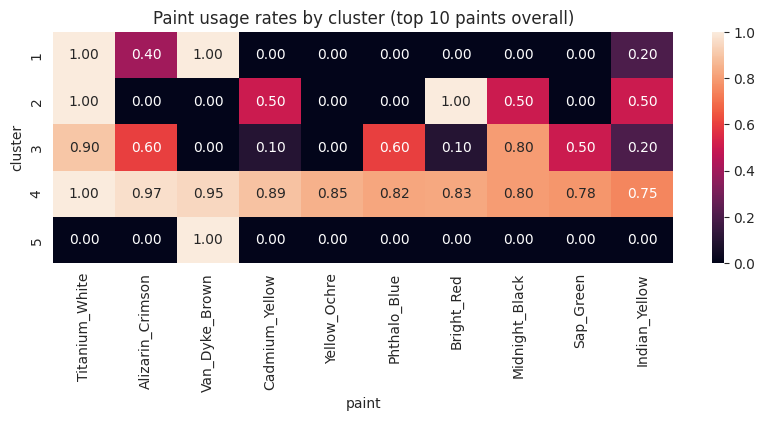

In [137]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()

top_paints = bob_ross[paint_cols].mean().sort_values(ascending=False).head(10).index
hm = cluster_paint_rates[top_paints]

plt.figure(figsize=(10,3))
sns.heatmap(hm, annot=True, fmt=".2f")
plt.title("Paint usage rates by cluster (top 10 paints overall)")
plt.xlabel("paint")
plt.ylabel("cluster")
plt.show()

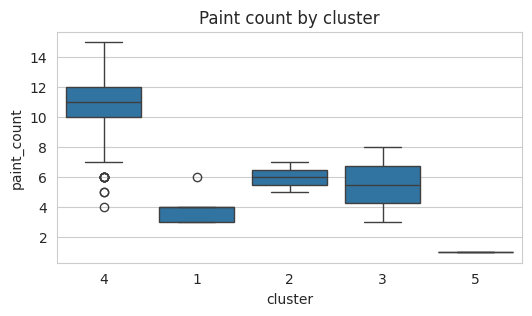

In [138]:
plt.figure(figsize=(6,3))
sns.boxplot(x="cluster_labels", y="paint_count", data=bob_ross)
plt.title("Paint count by cluster")
plt.xlabel("cluster")
plt.ylabel("paint_count")
plt.show()

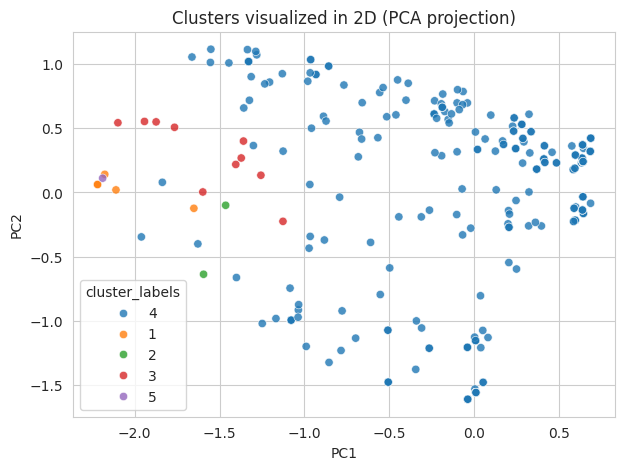

In [139]:
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster_labels"] = bob_ross["cluster_labels"].astype(str).values

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_labels", alpha=0.8)
plt.title("Clusters visualized in 2D (PCA projection)")
plt.show()


PCA is used only for visualization to project the high-dimensional binary palette vectors into 2D. It is not used for clustering or inference.

Overall, the clustering yields one dominant “common palette” group and a handful of much smaller groups that reflect less typical paint mixes. The heatmap shows that one cluster has consistently high usage rates across the top paints overall, which looks like a shared baseline palette rather than a niche combination. This interpretation is consistent with how Jaccard similarity behaves on binary data: shared core paints increase overlap and reduce distance, which naturally pulls many paintings into a dominant group.

###3.2. Method 2: Association Rules

In [140]:
X_bool_df = X.astype(bool)

df_rules = X_bool_df.copy()
df_rules["cluster_labels"] = bob_ross["cluster_labels"].values

display(df_rules.head())

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,cluster_labels
0,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
1,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
2,True,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,1
4,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4


Each painting is a line, and paint is a bool feature (appears/does not appear).

In [141]:
# Identify trivial paints
global_usage = X_bool_df.mean().sort_values(ascending=False)
display(global_usage.head(12))

TRIVIAL_THRESH = 0.95
trivial_paints = set(global_usage[global_usage >= TRIVIAL_THRESH].index)

print("Trivial paints (global usage >= 0.95):")
print(sorted(list(trivial_paints)))

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


Trivial paints (global usage >= 0.95):
['Titanium_White']


Judging from the results, I obtained Titanium_White at 0.992, which is the same as Method 1 that the previous explanation of the "common palette". It is because the shared base is too strong that super-large clusters naturally form, rather than code errors.

In [142]:
def mine_rules(df_bool, min_support=0.15, min_conf=0.6, min_lift=1.05, max_len=3):
    itemsets = apriori(df_bool, min_support=min_support, use_colnames=True, max_len=max_len)
    if itemsets.empty:
        return pd.DataFrame()
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf)
    if rules.empty:
        return pd.DataFrame()
    rules = rules[rules["lift"] >= min_lift].copy()
    if rules.empty:
        return pd.DataFrame()
    rules["antecedents"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(s)))
    rules["consequents"] = rules["consequents"].apply(lambda s: ", ".join(sorted(s)))
    return rules[["antecedents","consequents","support","confidence","lift"]].sort_values(
        ["lift","confidence","support"], ascending=False
    ).reset_index(drop=True)

I use Apriori to find frequent itemsets and then generate rules.

In [143]:
# Global baseline rules
X_global = X_bool_df.drop(columns=list(trivial_paints), errors="ignore").copy()

global_min_sup = 0.10
global_min_conf = 0.60
global_min_lift = 1.30
MAX_LEN = 3

rules_global = mine_rules(
    X_global.astype(bool),
    min_support=global_min_sup,
    min_conf=global_min_conf,
    min_lift=global_min_lift,
    max_len=MAX_LEN
)

print("\n=== Global rules (after removing trivial paints) ===")
display(rules_global.head(15))


=== Global rules (after removing trivial paints) ===


,antecedents,consequents,support,confidence,lift
0,Phthalo_Green,"Prussian_Blue, Sap_Green",0.205955,0.715517,1.393012
1,"Liquid_Clear, Van_Dyke_Brown",Dark_Sienna,0.106700,0.977273,1.358072
2,Dark_Sienna,"Midnight_Black, Van_Dyke_Brown",0.707196,0.982759,1.356342
3,"Midnight_Black, Van_Dyke_Brown",Dark_Sienna,0.707196,0.976027,1.356342
4,Phthalo_Green,"Phthalo_Blue, Prussian_Blue",0.191067,0.663793,1.344264
5,Phthalo_Green,"Bright_Red, Prussian_Blue",0.200993,0.698276,1.340025
6,Phthalo_Green,"Cadmium_Yellow, Prussian_Blue",0.210918,0.732759,1.318311
7,"Indian_Yellow, Midnight_Black",Dark_Sienna,0.555831,0.941176,1.307911
8,Dark_Sienna,"Indian_Yellow, Midnight_Black",0.555831,0.772414,1.307911
9,"Midnight_Black, Yellow_Ochre",Dark_Sienna,0.627792,0.940520,1.306999


I set the global baseline to compare whether the rules within the cluster are just globally common structures or cluster-specific. At the same time, Titanium_White global usage≈0.992, which occurs almost always, dominates the rules and reduces interpretability. Therefore, it is removed first to highlight the more informative co-occurrence relationship.

In [144]:
# Within-cluster rules
MIN_CLUSTER_N = 10
MIN_CONF = 0.60
MIN_LIFT = 1.30
MAX_LEN = 3

cluster_rules = {}

for cl in sorted(df_rules["cluster_labels"].unique()):
    sub = df_rules[df_rules["cluster_labels"] == cl].drop(columns=["cluster_labels"]).copy()
    n_cl = sub.shape[0]

    print(f"\n=== Cluster {cl} | n={n_cl} ===")

    if n_cl < MIN_CLUSTER_N:
        print("Too small for stable rules -> treat as rare palette case (skip rule mining).")
        continue

    sub = sub.drop(columns=list(trivial_paints), errors="ignore")

    min_sup = max(3 / n_cl, 0.10)
    print(f"min_support={min_sup:.3f}, min_conf={MIN_CONF:.2f}, min_lift={MIN_LIFT:.2f}")

    rules_cl = mine_rules(
        sub.astype(bool),
        min_support=min_sup,
        min_conf=MIN_CONF,
        min_lift=MIN_LIFT,
        max_len=MAX_LEN
    )

    if rules_cl.empty:
        print("No rules found under these thresholds.")
        continue

    display(rules_cl.head(12))
    cluster_rules[cl] = rules_cl


=== Cluster 1 | n=5 ===
Too small for stable rules -> treat as rare palette case (skip rule mining).

=== Cluster 2 | n=2 ===
Too small for stable rules -> treat as rare palette case (skip rule mining).

=== Cluster 3 | n=10 ===
min_support=0.300, min_conf=0.60, min_lift=1.30


,antecedents,consequents,support,confidence,lift
0,Liquid_Clear,"Black_Gesso, Sap_Green",0.3,1.00,2.5
1,"Black_Gesso, Sap_Green",Liquid_Clear,0.3,0.75,2.5
2,Liquid_Clear,Black_Gesso,0.3,1.00,2.0
3,Liquid_Clear,Sap_Green,0.3,1.00,2.0
4,"Liquid_Clear, Prussian_Blue",Black_Gesso,0.3,1.00,2.0
5,Liquid_Clear,"Black_Gesso, Prussian_Blue",0.3,1.00,2.0
6,"Liquid_Clear, Sap_Green",Black_Gesso,0.3,1.00,2.0
7,"Black_Gesso, Liquid_Clear",Sap_Green,0.3,1.00,2.0
8,"Black_Gesso, Midnight_Black",Sap_Green,0.3,1.00,2.0
9,"Alizarin_Crimson, Black_Gesso",Sap_Green,0.3,1.00,2.0



=== Cluster 4 | n=385 ===
min_support=0.100, min_conf=0.60, min_lift=1.30


,antecedents,consequents,support,confidence,lift
0,Phthalo_Green,"Prussian_Blue, Sap_Green",0.215584,0.715517,1.363733
1,Phthalo_Green,"Phthalo_Blue, Prussian_Blue",0.200000,0.663793,1.324147



=== Cluster 5 | n=1 ===
Too small for stable rules -> treat as rare palette case (skip rule mining).


When n is very small, for example, less than 5. Rules can be driven by a very small number of samples and are unstable. So I set MIN_CLUSTER_N=10. If it is less than 10, rule mining is not performed, but described using cluster-level usage/lift profile.

In [145]:
def rule_key(df):
    a = df["antecedents"].astype(str).str.strip()
    c = df["consequents"].astype(str).str.strip()
    return list(zip(a, c))

global_keys = set(rule_key(rules_global)) if (rules_global is not None and not rules_global.empty) else set()

for cl, rules_cl in cluster_rules.items():
    if rules_cl is None or rules_cl.empty:
        continue

    r = rules_cl.copy()
    r["is_global_common"] = rule_key(rules_cl)
    r["is_global_common"] = pd.Series(r["is_global_common"]).isin(global_keys).to_numpy()

    n_all = len(r)
    n_common = int(r["is_global_common"].sum())
    n_only = n_all - n_common

    print(f"\nCluster {cl}: {n_all} rules ({n_common} also appear globally), cluster-only = {n_only}")

    sig = (r[~r["is_global_common"]].sort_values(["lift", "confidence", "support"], ascending=False)[["antecedents","consequents","support","confidence","lift"]].head(12))
    if not sig.empty:
        display(sig)



Cluster 3: 43 rules (0 also appear globally), cluster-only = 43


,antecedents,consequents,support,confidence,lift
0,Liquid_Clear,"Black_Gesso, Sap_Green",0.3,1.00,2.5
1,"Black_Gesso, Sap_Green",Liquid_Clear,0.3,0.75,2.5
2,Liquid_Clear,Black_Gesso,0.3,1.00,2.0
3,Liquid_Clear,Sap_Green,0.3,1.00,2.0
4,"Liquid_Clear, Prussian_Blue",Black_Gesso,0.3,1.00,2.0
5,Liquid_Clear,"Black_Gesso, Prussian_Blue",0.3,1.00,2.0
6,"Liquid_Clear, Sap_Green",Black_Gesso,0.3,1.00,2.0
7,"Black_Gesso, Liquid_Clear",Sap_Green,0.3,1.00,2.0
8,"Black_Gesso, Midnight_Black",Sap_Green,0.3,1.00,2.0
9,"Alizarin_Crimson, Black_Gesso",Sap_Green,0.3,1.00,2.0



Cluster 4: 2 rules (2 also appear globally), cluster-only = 0


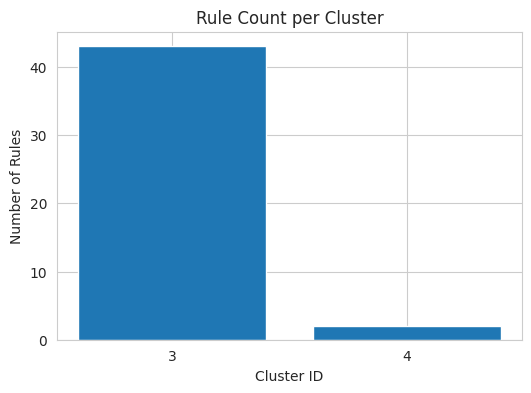

In [146]:
rule_counts = {cl: len(rules) for cl, rules in cluster_rules.items()}
plt.figure(figsize=(6,4))
plt.bar(rule_counts.keys(), rule_counts.values())
plt.xlabel("Cluster ID")
plt.ylabel("Number of Rules")
plt.title("Rule Count per Cluster")
plt.show()

Cluster 4 (n=385) yields only two high-lift rules under strict thresholds (min_lift=1.30), suggesting this large cluster mostly reflects the dataset’s common paint co-usage structure rather than a highly distinctive signature. In contrast, Cluster 3 (n=10) produces multiple high-lift, high-confidence rules centered on Liquid_Clear and Black_Gesso (support=0.30 = 3/10 paintings), indicating a more distinctive co-occurrence pattern that helps interpret this cluster as a rare palette archetype. Clusters with n < 10 are treated as rare/outlier cases because rules would be unstable and driven by very few paintings.

##4.Findings Summary

Bob Ross paintings do exhibit palette structure, but the structure is highly imbalanced.  
Clustering reveals one dominant “standard palette” used in most paintings, while a few small clusters represent rare but coherent palette archetypes.

Association rules confirm this pattern:  
- The dominant cluster produces almost no distinctive rules (generic palette).  
- Smaller clusters generate many high‑lift rules, indicating specialized and interpretable palette combinations.

Overall, the data supports the existence of a small number of interpretable palette archetypes, with one broad general‑purpose palette and several rare specialized variants.
